# Bright Sky Model
We want to create a better model for the moon.

In [ ]:
%pylab inline

In [4]:
import os, glob, sys, fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
from astropy.io import fits

import astropy.table
import astropy.units as u
from astropy.time import Time
import corner
import seaborn as sns

import sklearn.linear_model
import specsim.atmosphere
from scipy import interpolate
import statsmodels.api as sm 
from lmfit import models, Parameters, Parameter, Model
from scipy.optimize import curve_fit

import speclite
import astropy.units as u

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('small')

## Define Data
First, look at bright photometric data. Bright is defined as 2.5 x mean dark level, which is 2.79 $10^{-17} erg/cm^{2}/s/A$

In [5]:
data = astropy.table.Table.read('/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/data/good_data.fits')

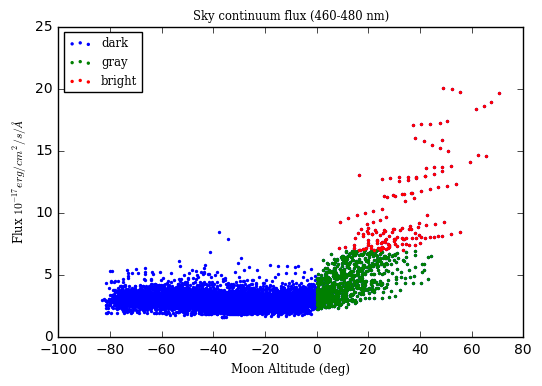

In [6]:
def make_data_dict(data = data, plot = False):
    gray_level = 2.5*2.79
    gray = np.where((data['MOON_ALT']>0)&(data['SKY_VALUE']<gray_level))
    bright = np.where((data['MOON_ALT']>0)&(data['SKY_VALUE']>gray_level))
        
    if plot:
        plt.figure()
        plt.scatter(data['MOON_ALT'], data['SKY_VALUE'], s = 2, color = 'b', label = 'dark')
        plt.scatter(data['MOON_ALT'][gray], data['SKY_VALUE'][gray], s = 2, color = 'g', label = 'gray')
        plt.scatter(data['MOON_ALT'][bright], data['SKY_VALUE'][bright], s = 2, color = 'r', label = 'bright')
        plt.legend(loc='upper left', prop=font)
        plt.xlabel("Moon Altitude (deg)", fontproperties = font)
        plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
        plt.title("Sky continuum flux (460-480 nm)", fontproperties = font)
     
    return {'good': data, 'gray': data[gray], 'bright': data[bright]}

data_dict = make_data_dict(plot=True)

In [7]:
# Add in clouds/photometricity
cloud_data = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/clouds/phot_rec.npy')
def get_cloud_data(line):
    df = pd.DataFrame(cloud_data)
    clouds = df[(df['STARTTAI']<= line['TAI-BEG']) & (df['ENDTAI']>line['TAI-BEG'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = df[(df['STARTTAI']< line['TAI-END']) & (df['ENDTAI']>=line['TAI-END'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = 0.5

    return clouds

In [8]:
clouds = [get_cloud_data(line) for line in data]
data['PHOTO'] = astropy.table.Column(np.hstack(clouds).astype(np.float32))
data_dict = make_data_dict()

In [9]:
def photometric_cut(data = data):
    phot_data = data[data['PHOTO'] == 1]
    phot_data_dict = make_data_dict(data = phot_data)
    return phot_data_dict
phot_data_dict = photometric_cut()

## How good is a linear regression model?
These results are only from the photometric bright nights. The linear regression fit is pretty good. It helps me identify components important to the moon model

(86, 22) (86,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1137.
Date:                Mon, 12 Feb 2018   Prob (F-statistic):           1.51e-74
Time:                        11:07:07   Log-Likelihood:                -62.224
No. Observations:                  86   AIC:                             168.4
Df Residuals:                      64   BIC:                             222.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
MOON_ILL       211.9161     19.60

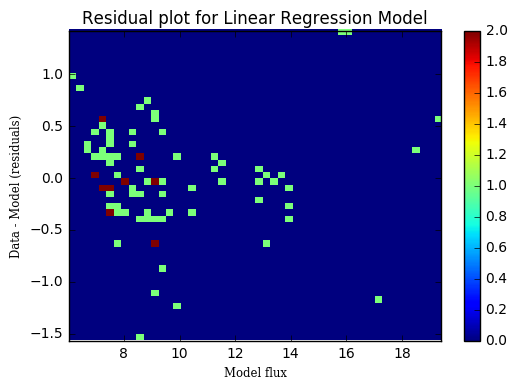

In [10]:
def linear_regression(data_name = 'bright', data_dict = data_dict):
    data = data_dict[data_name]
    #features = ['MOON_ILL','MOON_ALT','MOON_SEP','AIRMASS','AZ','SUN_MOON_SEP','MOON_D','SEEING50']
    features = ['MOON_ILL','MOON_ALT','MOON_SEP','AIRMASS','SUN_MOON_SEP',
                'ECL_LON','ECL_LAT','GAL_LAT','SEASON','HOUR','MOON_AZ',
                'PRESSURE','SUN_ALT','DUSTB','MOON_LAT','MOON_LON','AIRTEMP','DEWPOINT',
                'WINDS25M','GUSTS','HUMIDITY','MOON_D']

    X = []
    for feat in features:
        X.append(data[feat])
    X = np.column_stack(X)

    y = data['SKY_VALUE']
    print(X.shape, y.shape)

    sm.OLS.exog_names = features
    results = sm.OLS(y, X).fit()

    params = results.params
    model = np.dot(X, params)
    
    print(results.summary())
    

    xmin, xmax = np.percentile(model, (1, 99))
    ymin, ymax = np.percentile(y - model, (1, 99))
    plt.hist2d(model, y-model,bins=(50,50), cmap=plt.cm.jet)
    plt.colorbar()
    #plt.xlim(xmin, xmax)
    #plt.ylim(ymin, ymax)
    plt.xlabel("Model flux",fontproperties=font)
    plt.ylabel("Data - Model (residuals)",fontproperties=font)
    plt.title("Residual plot for Linear Regression Model")
linear_regression(data_name='bright', data_dict = phot_data_dict)

## Now, we want to create a better more physical model

In [11]:
wavelength = np.linspace(3550, 9350, (9350-3550)*10)*u.Angstrom
sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
area = 1 * u.arcsec ** 2

In [12]:
#moon spectrum
moon_s = np.loadtxt('/Users/parkerf/Research/SkyModel/DESI_Sky/solarspec.txt')
moon_s = interpolate.interp1d(moon_s[:,1], moon_s[:,2], bounds_error=False, fill_value = 0)
moon_spectrum = moon_s(wavelength)* u.erg/ (u.cm**2 * u.s * u.Angstrom)

#extinction curve
ext_c = np.loadtxt('/Users/parkerf/Research/SkyModel/DESI_Sky/ZenithExtinction-KPNO.dat')
ext_c = interpolate.interp1d(ext_c[:,0], ext_c[:,1], bounds_error=False, fill_value = 0)
extinction_coefficient = ext_c(wavelength)

In [13]:
moon_zenith = 90-data['MOON_ALT']
data['MOON_ZENITH'] = astropy.table.Column(moon_zenith.astype(np.float32), unit='deg')
# Compute the pointing zenith angle in degrees.
obs_zenith = 90 - data['ALT']
data['OBS_ZENITH'] = astropy.table.Column(obs_zenith.astype(np.float32), unit='deg')

mphase = np.arccos(2 * data['MOON_ILL'] - 1) / np.pi
data['MPHASE'] = astropy.table.Column(mphase.astype(np.float32))

helio_lon = data['ECL_LON'] - data['SUN_LON']
data['HELIO_LON'] = astropy.table.Column(np.array(helio_lon).astype(np.float32))

### Calculate Values for Moon Brightness

In [14]:
# Calculate the V-band extinction of the moon spectrum.
_vband = speclite.filters.load_filter('bessell-V')
V = _vband.get_ab_magnitude(moon_spectrum, wavelength)
extinction = 10 ** (-extinction_coefficient / 2.5)
Vstar = _vband.get_ab_magnitude(
    moon_spectrum * extinction, wavelength)
_vband_extinction = Vstar - V

In [15]:
#Calculate the wavelength-dependent extinction of moonlight
# scattered once into the observed field of view.
idx = np.where((wavelength>4600*u.Angstrom)&(wavelength<4800*u.Angstrom))
ext = np.array(extinction_coefficient)

scattering_airmass = np.array((
    1 - 0.96 * np.sin(data['MOON_ZENITH']) ** 2) ** (-0.5))
data['scatt_airmass'] = astropy.table.Column(scattering_airmass.astype(np.float32))

In [16]:
RAWV = []
MEAN_EXT = []
for item in data:
    extinction = (10 ** ((-ext * item['scatt_airmass']) / 2.5) *
        (1 - 10 ** (-ext * item['AIRMASS'] / 2.5)))
    surface_brightness = moon_spectrum * extinction

    # Renormalized the extincted spectrum to the correct V-band magnitude.
    raw_V = _vband.get_ab_magnitude(
        surface_brightness, wavelength) * u.mag
    RAWV.append(raw_V.value)
    
    idx = np.where((wavelength>4400*u.Angstrom)&(wavelength<4800*u.Angstrom))
    MEAN_EXT.append(np.mean(extinction[idx]))
    
data['raw_V'] = astropy.table.Column(np.array(RAWV).astype(np.float32))
data['mean_ext'] = astropy.table.Column(np.array(MEAN_EXT).astype(np.float32))

### Calculate values for Zodiacal light

In [16]:
leinert_lookup = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/files/leinert_lookup_interp.npy'
ZodiLookup = np.load(leinert_lookup)
S10 = 1.28*10**(-9) #erg/cm2/s/sr/A  @ 500nm
sr = 4.25*10**(10) #arcsec^2/sr
fiber_area = np.pi

In [17]:
hdu = fits.open('ftp://ftp.stsci.edu/cdbs/current_calspec/sun_reference_stis_002.fits')
sun_spectrum = hdu[1].data
hdu.close()
sun_wave = sun_spectrum['WAVELENGTH']/10. #nm
sun_flux = sun_spectrum['FLUX'] #erg/s/cm2/A 
sun_spectrum = interpolate.interp1d(sun_wave, sun_flux, bounds_error = False, fill_value = 0)
#relative to 500nm
nm_500 = [np.abs(500.-w) for w in sun_wave]
nm_id = np.argmin(nm_500)
relative_sun_flux = sun_flux/sun_flux[nm_id]

In [18]:
ZODI = []
for line in data:
    lamb = np.argmin([np.abs(np.abs(line['HELIO_LON'])-lon) for lon in ZodiLookup[0]])
    beta = np.argmin([np.abs(np.abs(line['ECL_LAT'])-lat) for lat in ZodiLookup[1]])
    BASE_ZODI = ZodiLookup[2][lamb][beta]
    
    IO = BASE_ZODI*S10*(fiber_area/sr)
    flux = relative_sun_flux*IO*10**17
    zodi_spect = interpolate.interp1d(sun_wave*10, flux, bounds_error=False, fill_value=0)
    ext = 10 ** (-extinction_coefficient * line['AIRMASS'] / 2.5)
    zodi_flux = zodi_spect(wavelength)*ext*u.erg/ (u.cm**2 * u.s * u.Angstrom)
    idx = np.where((wavelength>4600*u.Angstrom)&(wavelength<4800*u.Angstrom))
    ZODI.append(np.mean(zodi_flux[idx]).value)
data['ZODI'] = astropy.table.Column(np.array(ZODI).astype(np.float32))

In [19]:
data_dict = make_data_dict()
phot_data_dict = photometric_cut()
this_data = np.random.choice(phot_data_dict['bright'],1)

In [1]:
def BrightModel(data):
    def bright_sky_model(x, A, B, AT, SE, H, DP,  a1, a2, a3, a4, a5, a6, a7, a8):
        moon_ill, moon_sep, airmass, Xmoon, raw_V, mean_ext, zodi, season, dust, moon_lat, airtemp,dewpoint, pressure, hour = x

        #The following is from the specsim.atmosphere model with constants in place
        abs_alpha = 180. * moon_ill
        m = -a1 + a2 * abs_alpha + a3 *10**(-9) * abs_alpha ** 4

        # Calculate the illuminance of the moon outside the atmosphere in
        # foot-candles (eqn. 8).
        Istar = 10 ** (-0.4 * (m + a4))

        # Calculate the scattering function (eqn.21).
        rho = moon_sep #separation_angle.to(u.deg).value
        f_scatter = (10 ** a5 * (a6 + np.cos(np.deg2rad(rho)) ** 2) +
                     10 ** (a7 - rho / a8))

        # Calculate the V-band moon surface brightness in nanoLamberts.
        B_moon = (f_scatter * Istar *
            10 ** (-0.4 * _vband_extinction * Xmoon) *
            (1 - 10 ** (-0.4 * (_vband_extinction * airmass))))

        # Convert from nanoLamberts to to mag / arcsec**2 using eqn.19 of
        # Garstang, "Model for Artificial Night-Sky Illumination",
        # PASP, vol. 98, Mar. 1986, p. 364 (http://dx.doi.org/10.1086/131768)
        _scattered_V =  ((20.7233 - np.log(B_moon / 34.08)) / 0.92104 *
                u.mag / (u.arcsec ** 2))

        idx = np.where((wavelength>4600*u.Angstrom)&(wavelength<4800*u.Angstrom))
        surface_brightness = np.mean(moon_spectrum[idx]) * mean_ext

        area = 1 * u.arcsec ** 2

        surface_brightness *= 10 ** (
            -(_scattered_V * area - raw_V * u.mag) / (2.5 * u.mag)) 

        moon =  (surface_brightness*10**17).value
        sky = A*zodi + moon   #+SE*season + H*hour+  AT*airtemp + DP*dewpoint 

        return sky
    
    mod = Model(bright_sky_model)
    
    params = mod.make_params()

    params.add('A', value = 1)
    params.add('B', value = 0)
    params.add('AT', value = 0.24)
    params.add('DP', value = -0.1162)
    params.add('SE', value = -.26)
    params.add('H', value = -0.3)
    
    params.add('a1', value = 12.73, min = 0, max = 20)
    params.add('a2', value = 0.025, min = .001, max = 1)
    params.add('a3', value = 4, min = 0) #4*10**(-9)
    params.add('a4', value = 16.57, min = 0, max = 20)
    params.add('a5', value = 5.36, min = 0, max = 10)
    params.add('a6', value = 1.06, min = 0, max = 5)
    params.add('a7', value = 6.15, min = 0, max = 10)
    params.add('a8', value = 40., min = 0, max = 100)
    
    xx = np.array([data['MOON_ILL'], data['MOON_SEP'], data['AIRMASS'],data['scatt_airmass'], data['raw_V'], 
      data['mean_ext'], data['ZODI'], data['SEASON'], data['DUSTB'], data['MOON_LAT'], data['AIRTEMP'], data['DEWPOINT'],
                  data['PRESSURE'], data['HOUR']])
    
    #print(mod.eval(params, x = xx))
    result = mod.fit(np.array(data['SKY_VALUE']), params, x = xx)
    print(result.fit_report())
    return result

In [2]:
my_data = phot_data_dict['bright']
model = BrightModel(my_data)

NameError: name 'phot_data_dict' is not defined

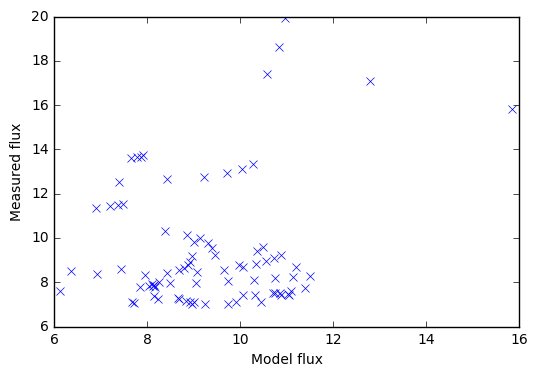

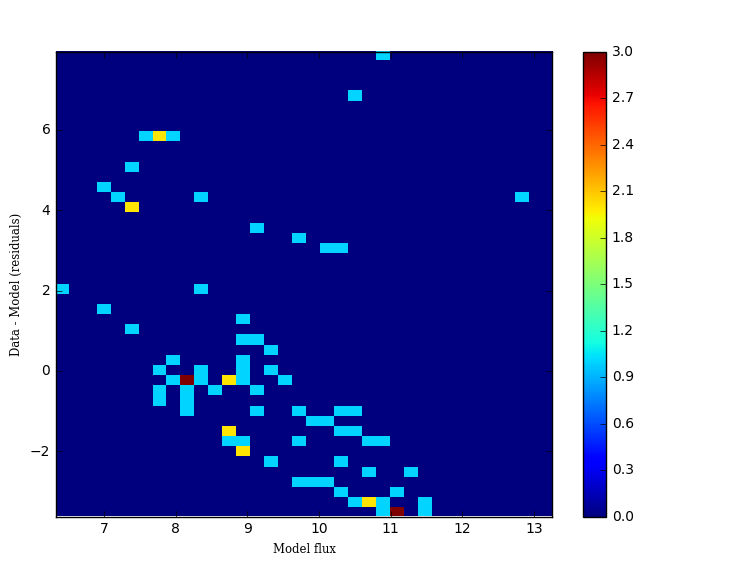

In [25]:
model = model.best_fit
res = my_data['SKY_VALUE']-model

plt.figure()
plt.plot(model, my_data['SKY_VALUE'],'x')
plt.xlabel("Model flux")
plt.ylabel("Measured flux")
fig, ax = plt.subplots(1, figsize=(8,6))

xmin, xmax = np.percentile(model, (1, 99))
ymin, ymax = np.percentile(res, (1, 99))
plt.hist2d(model, res,bins=(50,50), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel("Model flux",fontproperties=font)
plt.ylabel("Data - Model (residuals)",fontproperties=font)


In [26]:
my_data = phot_data_dict['good']
model = BrightModel(my_data)

[[Model]]
    Model(bright_sky_model)
[[Fit Statistics]]
    # function evals   = 2212
    # data points      = 3428
    # variables        = 14
    chi-square         = 5006.217
    reduced chi-square = 1.466
    Akaike info crit   = 1326.196
    Bayesian info crit = 1412.152
[[Variables]]
    A:    0.71190763 +/- 0        (0.00%) (init= 1)
    B:    0          +/- 0        (nan%) (init= 0)
    AT:   0.24000000 +/- 0        (0.00%) (init= 0.24)
    SE:  -0.26000000 +/- 0        (0.00%) (init=-0.26)
    H:   -0.30000000 +/- 0        (0.00%) (init=-0.3)
    DP:  -0.11620000 +/- 0        (0.00%) (init=-0.1162)
    a1:   15.8417624 +/- 0        (0.00%) (init= 12.73)
    a2:   3.1440e-12 +/- 0        (0.00%) (init= 0.025)
    a3:   5.3500e-10 +/- 0        (0.00%) (init= 4)
    a4:   15.0913110 +/- 0        (0.00%) (init= 16.57)
    a5:   2.52625515 +/- 0        (0.00%) (init= 5.36)
    a6:   0.66487193 +/- 0        (0.00%) (init= 1.06)
    a7:   3.60318682 +/- 0        (0.00%) (init= 6.15)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


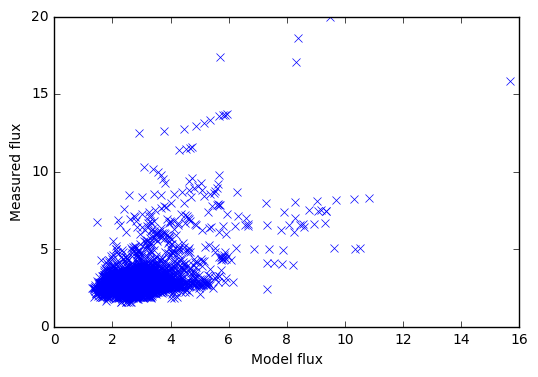

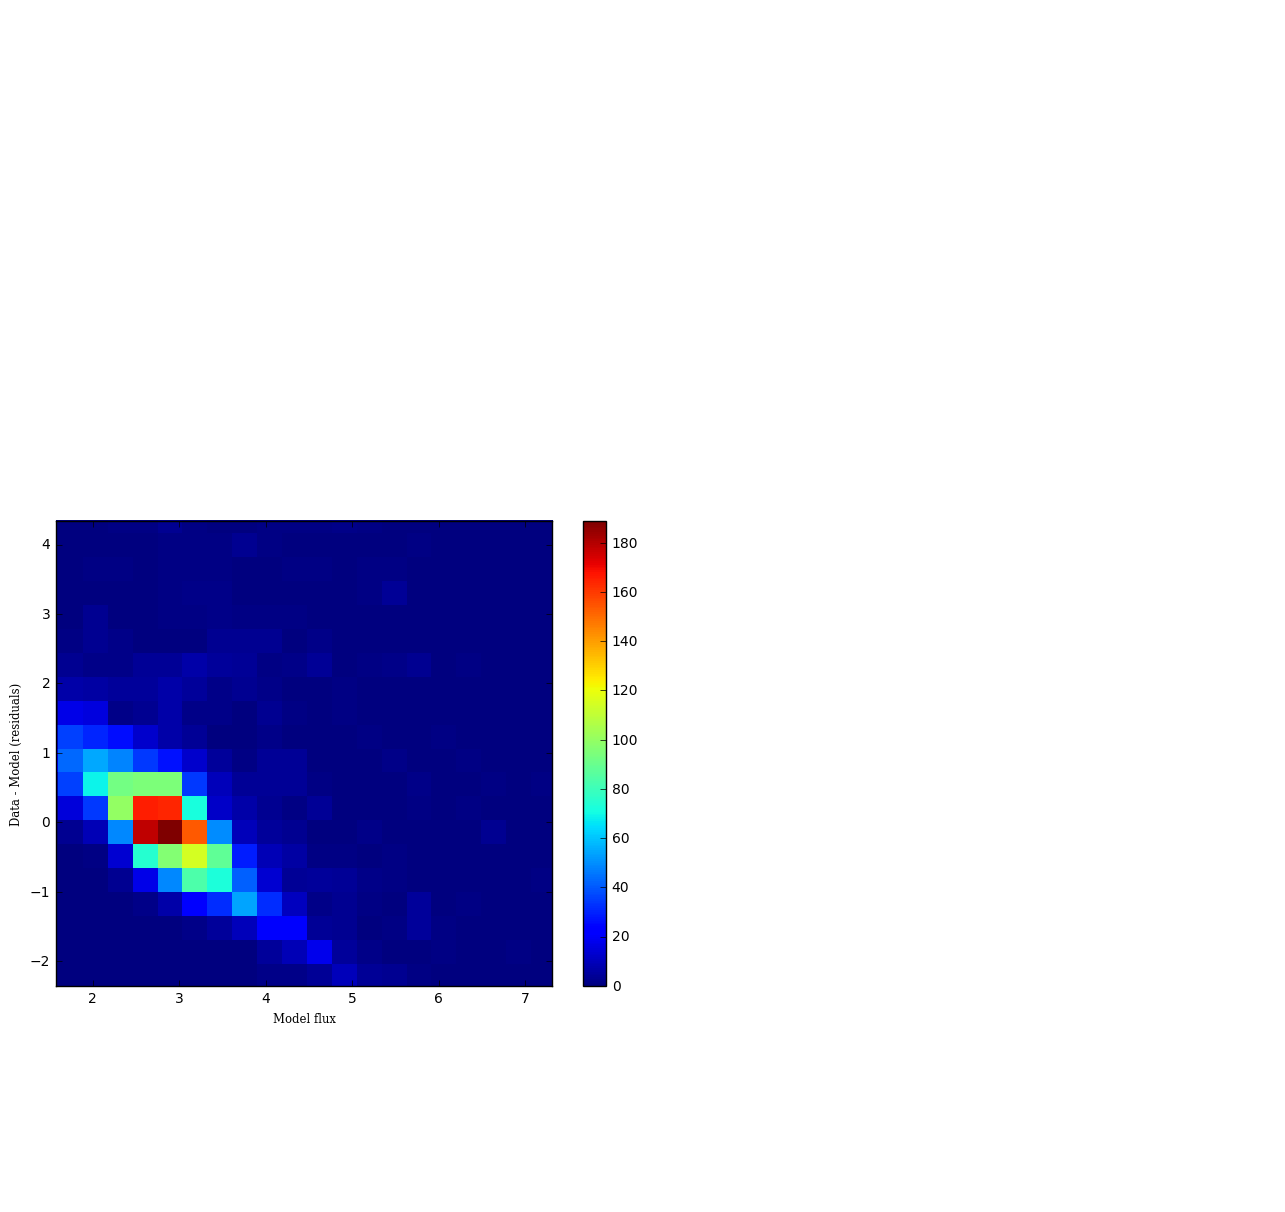

In [27]:
model = model.best_fit
res = my_data['SKY_VALUE']-model

plt.figure()
plt.plot(model, my_data['SKY_VALUE'],'x')
plt.xlabel("Model flux")
plt.ylabel("Measured flux")
fig, ax = plt.subplots(1, figsize=(8,6))

xmin, xmax = np.percentile(model, (1, 99))
ymin, ymax = np.percentile(res, (1, 99))
plt.hist2d(model, res,bins=(50,50), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel("Model flux",fontproperties=font)
plt.ylabel("Data - Model (residuals)",fontproperties=font)